# **[ Data & Packages ]**

In [2]:
# !pip install openpyxl
import openpyxl
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import missingno as msno
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from yellowbrick.target import FeatureCorrelation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


# # !pip install matplotlib --upgrade
# !pip install shap
# !pip install pdpbox
# import shap
# import skimage
from pdpbox import pdp
from matplotlib.pyplot import style

In [3]:
Total = pd.read_excel("../DAT/Odor data.xlsx", engine = "openpyxl", sheet_name = 0)
# Total.head(3)

In [4]:
Bound = pd.read_excel("../DAT/Odor data.xlsx", engine = "openpyxl", sheet_name = 1, header = None).T
Bound.columns = Bound.iloc[0,:]
Bound = Bound.iloc[1:-2, :]
Bound["spot"] = ["boundary"]*Bound.shape[0]
print(Bound.shape)
# Bound.head(3)

(75, 19)


In [5]:
In = pd.read_excel("../DAT/Odor data.xlsx", engine = "openpyxl", sheet_name = 2, header = None).T
In.columns = In.iloc[0,:]
In = In.iloc[1:-2, :]
In["spot"] = ["in"]*In.shape[0]
print(In.shape)
# In.head(3)

(59, 19)


In [6]:
Out = pd.read_excel("../DAT/Odor data.xlsx", engine = "openpyxl", sheet_name = 3, header = None).T
Out.columns = Out.iloc[0,:]
Out = Out.iloc[1:-2, :]
Out["spot"] = ["out"]*Out.shape[0]
print(Out.shape)
# Out.head(3)

(80, 19)


In [7]:
data = pd.concat([Bound, In, Out], axis = 0).reset_index(drop = True)
data.rename(columns = {"농장명" : "farm"}, inplace = True)
data.rename(columns = {"측정일" : "time"}, inplace = True)
display(data.head(3))
print(Total.shape, data.shape)
# data.to_csv("../DAT/total data.csv", header = True, index = False)

,time,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,farm,spot
0,18.04.24,NaN,NaN,NaN,NaN,NaN,NaN,1272.66,354.403,0.155839,10.1361,0.729858,6.97155,75.6197,0.05,0.05,5.04564,양지,boundary
1,18.05.08,NaN,NaN,NaN,NaN,NaN,NaN,34.2342,15.9551,2.02401,20.6026,1.58968,9.4874,4.14521,1.14226,0.848513,4.96098,양지,boundary
2,18.05.15,NaN,NaN,NaN,NaN,NaN,NaN,22.9287,7.22866,0.95165,5.77292,0.132276,5.32921,3.25102,0.980568,0.495689,4.80151,양지,boundary


(214, 17) (214, 19)


In [8]:
data.describe()

,time,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,farm,spot
count,214,209,200.00,209.00,209.00,209.00,209.00,209.00,209.00,209.00,208.00,209.00,209.00,209.00,209.00,209.0,209.00,214,214
unique,33,32,154.00,189.00,60.00,48.00,18.00,180.00,178.00,144.00,171.00,164.00,157.00,142.00,148.00,105.0,121.00,24,3
top,18.10.24,300,0.06,0.07,0.06,0.06,0.05,6.94,1.95,0.93,0.52,0.53,0.49,0.78,0.42,0.4,0.38,양지,out
freq,15,19,9.00,3.00,72.00,79.00,90.00,12.00,6.00,25.00,11.00,15.00,18.00,10.00,18.00,34.0,36.00,52,80


# **[ Preprocessing 1 ]**

## **_Missing**

In [9]:
na, nd = data.isna().sum().sum(), (data == "ND").sum().sum()
print("[대체 전] NA : {}개, ND {}개  결측값 총 {}개".format(na, nd, na+nd))

[대체 전] NA : 90개, ND 23개  결측값 총 113개


,time,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,farm,spot
Missing,0.0,5.0,14.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0,6.0,7.0,5.0,10.0,5.0,19.0,6.0,0.0,0.0
Missing (%),0.0,2.3,6.5,2.3,2.3,2.3,2.3,2.3,2.8,2.3,2.8,3.3,2.3,4.7,2.3,8.9,2.8,0.0,0.0


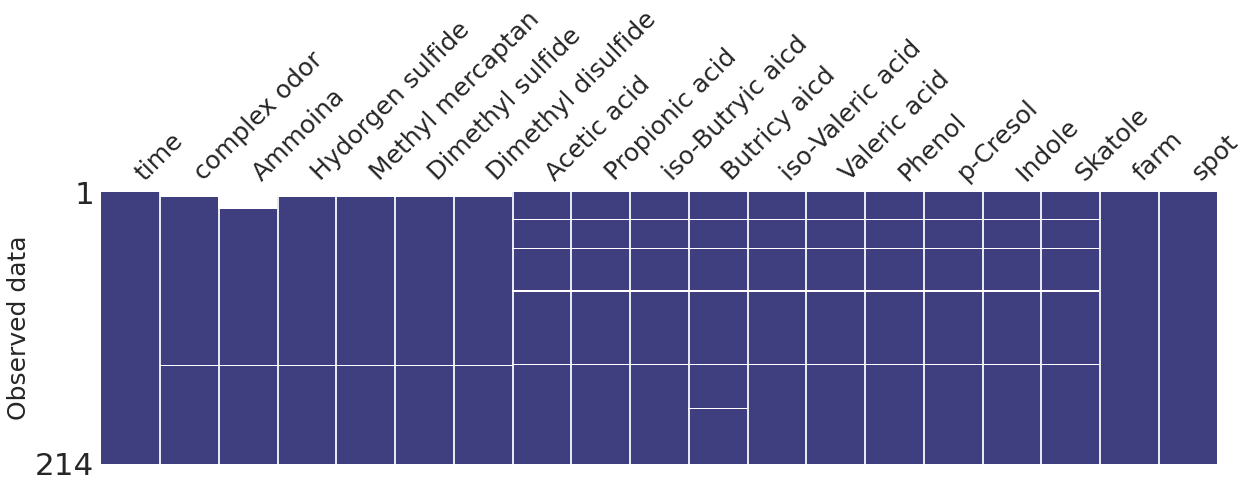

In [10]:
missing = pd.DataFrame((data.isna().sum() + (data == "ND").sum()).astype(int), columns = ["Missing"]).transpose()
missing_per = np.round(missing/data.shape[0], 3)
missing_per.index = ["Missing (%)"]

na_df = pd.concat([missing, missing_per*100], axis = 0)
display(na_df)

msno.matrix(data.iloc[:, :], figsize = (20, 5), fontsize = 25, sparkline = False, color = (0.25, 0.25, 0.5))
plt.ylabel("Observed data", fontsize = 25)
plt.savefig('Missing map.png', dpi = 300);

In [11]:
data[data=="ND"] = np.nan
imp_data = IterativeImputer(max_iter = 10000, estimator = BayesianRidge(), min_value = 0, random_state = 99).fit_transform(data.iloc[:,1:-2])
imp_data = pd.DataFrame(imp_data, columns = data.columns[1:-2])
imp_data = pd.concat([imp_data, data.loc[:,["time", "spot", "farm"]]], axis = 1)
print(imp_data.shape)
display(imp_data.head())

(214, 19)


,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,time,spot,farm
0,1314.204414,10.374437,149.737225,15.883465,0.00,0.166644,1272.659247,354.403061,0.155839,10.136117,0.729858,6.971546,75.619672,0.050000,0.050000,5.045635,18.04.24,boundary,양지
1,398.443371,1.605300,127.205918,4.587934,0.00,0.116850,34.234155,15.955100,2.024014,20.602569,1.589685,9.487402,4.145208,1.142263,0.848513,4.960978,18.05.08,boundary,양지
2,350.245307,1.618517,118.306453,4.675428,0.00,0.117278,22.928672,7.228658,0.951650,5.772918,0.132276,5.329210,3.251023,0.980568,0.495689,4.801511,18.05.15,boundary,양지
3,369.329538,1.621378,122.894983,4.625260,0.00,0.118621,30.939140,11.723489,1.293944,14.243849,1.143957,8.039261,4.624998,1.041485,0.050000,2.684469,18.05.22,boundary,양지
4,10.000000,1.051810,0.250000,0.070000,0.07,0.020000,17.534394,6.671902,1.246475,1.492030,0.080000,1.798373,1.615309,0.858109,0.050000,2.611138,18.05.29,boundary,양지


In [12]:
imp_na, imp_nd = imp_data.isna().sum().sum(), (imp_data == "ND").sum().sum()
print("[대체 후] NA : {}개, ND {}개  결측값 총 {}개".format(imp_na, imp_nd, imp_na+imp_nd))

[대체 후] NA : 0개, ND 0개  결측값 총 0개


In [13]:
imp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   complex odor        214 non-null    float64
 1   Ammoina             214 non-null    float64
 2   Hydorgen sulfide    214 non-null    float64
 3   Methyl mercaptan    214 non-null    float64
 4   Dimethyl sulfide    214 non-null    float64
 5   Dimethyl disulfide  214 non-null    float64
 6   Acetic acid         214 non-null    float64
 7   Propionic acid      214 non-null    float64
 8   iso-Butryic aicd    214 non-null    float64
 9   Butricy aicd        214 non-null    float64
 10  iso-Valeric acid    214 non-null    float64
 11  Valeric acid        214 non-null    float64
 12  Phenol              214 non-null    float64
 13  p-Cresol            214 non-null    float64
 14  Indole              214 non-null    float64
 15  Skatole             214 non-null    float64
 16  time    

In [14]:
imp_data.describe()

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,800.163628,2.719187,208.504564,6.036138,5.645000,0.120886,240.518527,184.056677,19.274839,159.935271,46.070684,85.779980,6.776365,34.274496,2.180159,3.146989
std,1467.055293,3.991345,386.961967,15.532600,40.506781,0.437492,407.899098,291.465839,37.080599,262.032551,83.601734,192.728419,12.697315,60.144648,7.077663,9.153247
min,3.000000,0.000000,0.040000,0.060000,0.000000,0.020000,0.150000,0.130000,0.040000,0.520000,0.080000,0.280000,0.060000,0.000000,0.014805,0.040000
25%,30.000000,0.182500,2.595000,0.060000,0.060000,0.040000,5.857500,2.100000,0.930000,1.625000,1.230000,1.500000,0.500000,0.420000,0.400000,0.380000
50%,300.000000,1.057929,56.250000,0.070000,0.080000,0.050000,27.809607,17.700000,2.012007,7.933551,4.415000,5.514649,1.846162,2.889172,0.858255,1.515000
75%,991.250000,3.437112,255.000000,4.420950,0.080000,0.050000,344.109226,347.855686,33.248576,209.982500,70.178955,105.516206,9.215300,54.789411,2.054087,3.486413
max,10000.000000,22.240000,2484.000000,120.000000,462.000000,4.280000,2446.000000,2109.686277,380.000000,1455.517596,743.688019,1869.402457,125.715578,481.200671,95.280000,127.130000


## **_Categorical**

### **__1. Spot**

In [15]:
### Spot  ->  One-Hot Encoding
encode_spot = pd.get_dummies(imp_data["spot"])
en_data = pd.concat([imp_data.drop(columns = "spot"), encode_spot], axis = 1)
en_data.head(3)

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,Valeric acid,Phenol,p-Cresol,Indole,Skatole,time,farm,boundary,in,out
0,1314.204414,10.374437,149.737225,15.883465,0.0,0.166644,1272.659247,354.403061,0.155839,10.136117,...,6.971546,75.619672,0.050000,0.050000,5.045635,18.04.24,양지,1,0,0
1,398.443371,1.605300,127.205918,4.587934,0.0,0.116850,34.234155,15.955100,2.024014,20.602569,...,9.487402,4.145208,1.142263,0.848513,4.960978,18.05.08,양지,1,0,0
2,350.245307,1.618517,118.306453,4.675428,0.0,0.117278,22.928672,7.228658,0.951650,5.772918,...,5.329210,3.251023,0.980568,0.495689,4.801511,18.05.15,양지,1,0,0


In [16]:
en_data.iloc[:-8:]

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,Valeric acid,Phenol,p-Cresol,Indole,Skatole,time,farm,boundary,in,out
0,1314.204414,10.374437,149.737225,15.883465,0.00,0.166644,1272.659247,354.403061,0.155839,10.136117,...,6.971546,75.619672,0.050000,0.050000,5.045635,18.04.24,양지,1,0,0
1,398.443371,1.605300,127.205918,4.587934,0.00,0.116850,34.234155,15.955100,2.024014,20.602569,...,9.487402,4.145208,1.142263,0.848513,4.960978,18.05.08,양지,1,0,0
2,350.245307,1.618517,118.306453,4.675428,0.00,0.117278,22.928672,7.228658,0.951650,5.772918,...,5.329210,3.251023,0.980568,0.495689,4.801511,18.05.15,양지,1,0,0
3,369.329538,1.621378,122.894983,4.625260,0.00,0.118621,30.939140,11.723489,1.293944,14.243849,...,8.039261,4.624998,1.041485,0.050000,2.684469,18.05.22,양지,1,0,0
4,10.000000,1.051810,0.250000,0.070000,0.07,0.020000,17.534394,6.671902,1.246475,1.492030,...,1.798373,1.615309,0.858109,0.050000,2.611138,18.05.29,양지,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,300.000000,6.960000,52.200000,0.060000,0.06,0.050000,225.470000,88.890000,14.710000,88.770000,...,11.840000,8.800000,345.000000,0.610000,0.660000,18.10.31,세희,0,0,1
202,66.000000,0.200000,4.530000,0.060000,0.06,0.050000,0.950000,0.370000,0.070000,1.000000,...,1.580000,0.200000,1.150000,0.290000,0.270000,18.10.31,송원,0,0,1
203,100.000000,0.140000,12.800000,0.060000,0.06,0.050000,1.400000,0.340000,0.070000,0.800000,...,1.570000,0.200000,1.150000,0.290000,0.270000,18.10.31,평지,0,0,1
204,96.000000,0.120000,0.970000,2.650000,1.17,0.720000,1.430000,0.520000,0.070000,0.980000,...,1.570000,0.200000,1.120000,0.290000,0.270000,18.10.31,마령생축,0,0,1


In [17]:
print("Boundary : {} 개, In : {} 개, Out : {} 개".format(en_data["boundary"].sum(), en_data["in"].sum(), en_data["out"].sum()))

Boundary : 75 개, In : 59 개, Out : 80 개


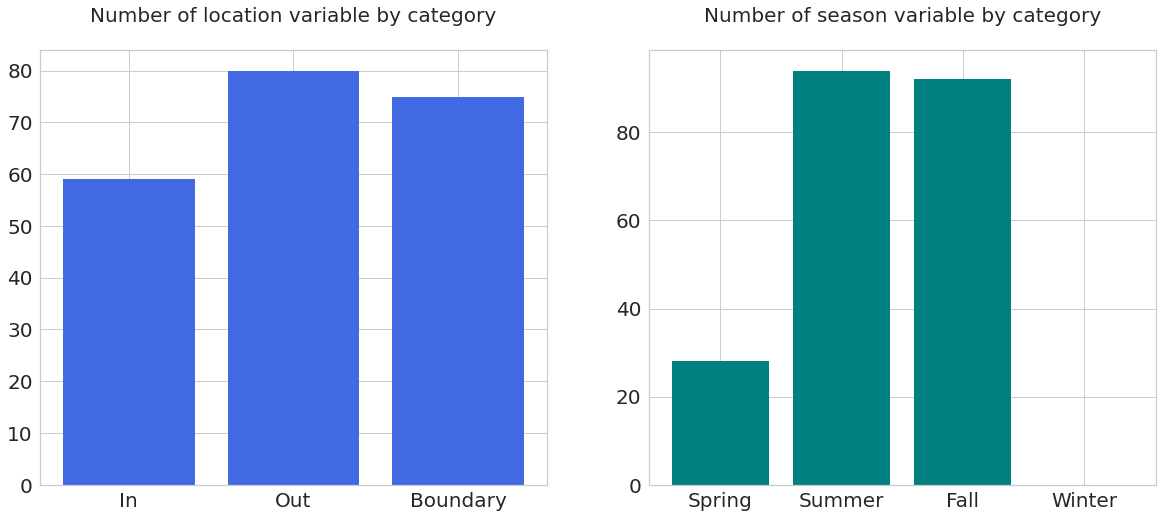

In [22]:
plt.figure(figsize = (20, 8))

plt.subplot(1,2,1)
plt.bar(x = ["In", "Out", "Boundary"], height = [en_data["in"].sum(), en_data["out"].sum(), en_data["boundary"].sum()], color = "royalblue")
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title("Number of location variable by category\n", fontsize = 20)

plt.subplot(1,2,2)
plt.bar(x = ["Spring", "Summer", "Fall", "Winter"], height = [en_data["spring"].sum(), en_data["summer"].sum(), en_data["fall"].sum(), 0], color = "teal")
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title("Number of season variable by category\n", fontsize = 20)
plt.savefig('Category data', dpi = 300);

### **__2. Month**

In [19]:
### 측정일  ->  월(month)만 사용, 문자열로 저장
en_data["Month"] = [en_data.loc[i, "time"][3:5] for i in range(en_data.shape[0])]
en_data.drop(columns = "time", inplace = True)

### 12개월  ->  4분기
x = en_data["Month"].astype("int")
condlist = [((x >= 3) & (x <= 5)), ((x >= 6) & (x <= 8)), ((x >= 9) & (x <= 11))]
choicelist = ["spring", "summer", "fall"]
en_data["season"] = np.select(condlist, choicelist, "winter")
en_data.drop(columns = "Month", inplace = True)

### season  ->  One-Hot Encoding
encode_season = pd.get_dummies(en_data["season"])
en_data = pd.concat([en_data.drop(columns = "season"), encode_season], axis = 1)
en_data.head(3)

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,p-Cresol,Indole,Skatole,farm,boundary,in,out,fall,spring,summer
0,1314.204414,10.374437,149.737225,15.883465,0.0,0.166644,1272.659247,354.403061,0.155839,10.136117,...,0.050000,0.050000,5.045635,양지,1,0,0,0,1,0
1,398.443371,1.605300,127.205918,4.587934,0.0,0.116850,34.234155,15.955100,2.024014,20.602569,...,1.142263,0.848513,4.960978,양지,1,0,0,0,1,0
2,350.245307,1.618517,118.306453,4.675428,0.0,0.117278,22.928672,7.228658,0.951650,5.772918,...,0.980568,0.495689,4.801511,양지,1,0,0,0,1,0


In [20]:
print("Spring : {} 개, Summer : {} 개, Fall : {} 개, Winter : {} 개".format(en_data["spring"].sum(), en_data["summer"].sum(), en_data["fall"].sum(), 0))

Spring : 28 개, Summer : 94 개, Fall : 92 개, Winter : 0 개


### **__3. farm**

In [26]:
pd.DataFrame(imp_data["farm"].value_counts()).T

,양지,에벤,요아킴,대성1,대성2,할레루야2,할렐루야1,점박이,평지,임마누엘,...,송원,가람,대영,주몽2,하나,주몽,씨알,해뜸,주몽1,가람
farm,52,33,12,12,12,12,12,7,6,6,...,6,5,3,2,2,2,2,2,1,1


In [27]:
### farm 변수는 제거
en_data.drop(columns = "farm", inplace = True)
en_data.head(3)

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,Phenol,p-Cresol,Indole,Skatole,boundary,in,out,fall,spring,summer
0,1314.204414,10.374437,149.737225,15.883465,0.0,0.166644,1272.659247,354.403061,0.155839,10.136117,...,75.619672,0.050000,0.050000,5.045635,1,0,0,0,1,0
1,398.443371,1.605300,127.205918,4.587934,0.0,0.116850,34.234155,15.955100,2.024014,20.602569,...,4.145208,1.142263,0.848513,4.960978,1,0,0,0,1,0
2,350.245307,1.618517,118.306453,4.675428,0.0,0.117278,22.928672,7.228658,0.951650,5.772918,...,3.251023,0.980568,0.495689,4.801511,1,0,0,0,1,0


## **_Correlation and VIF**

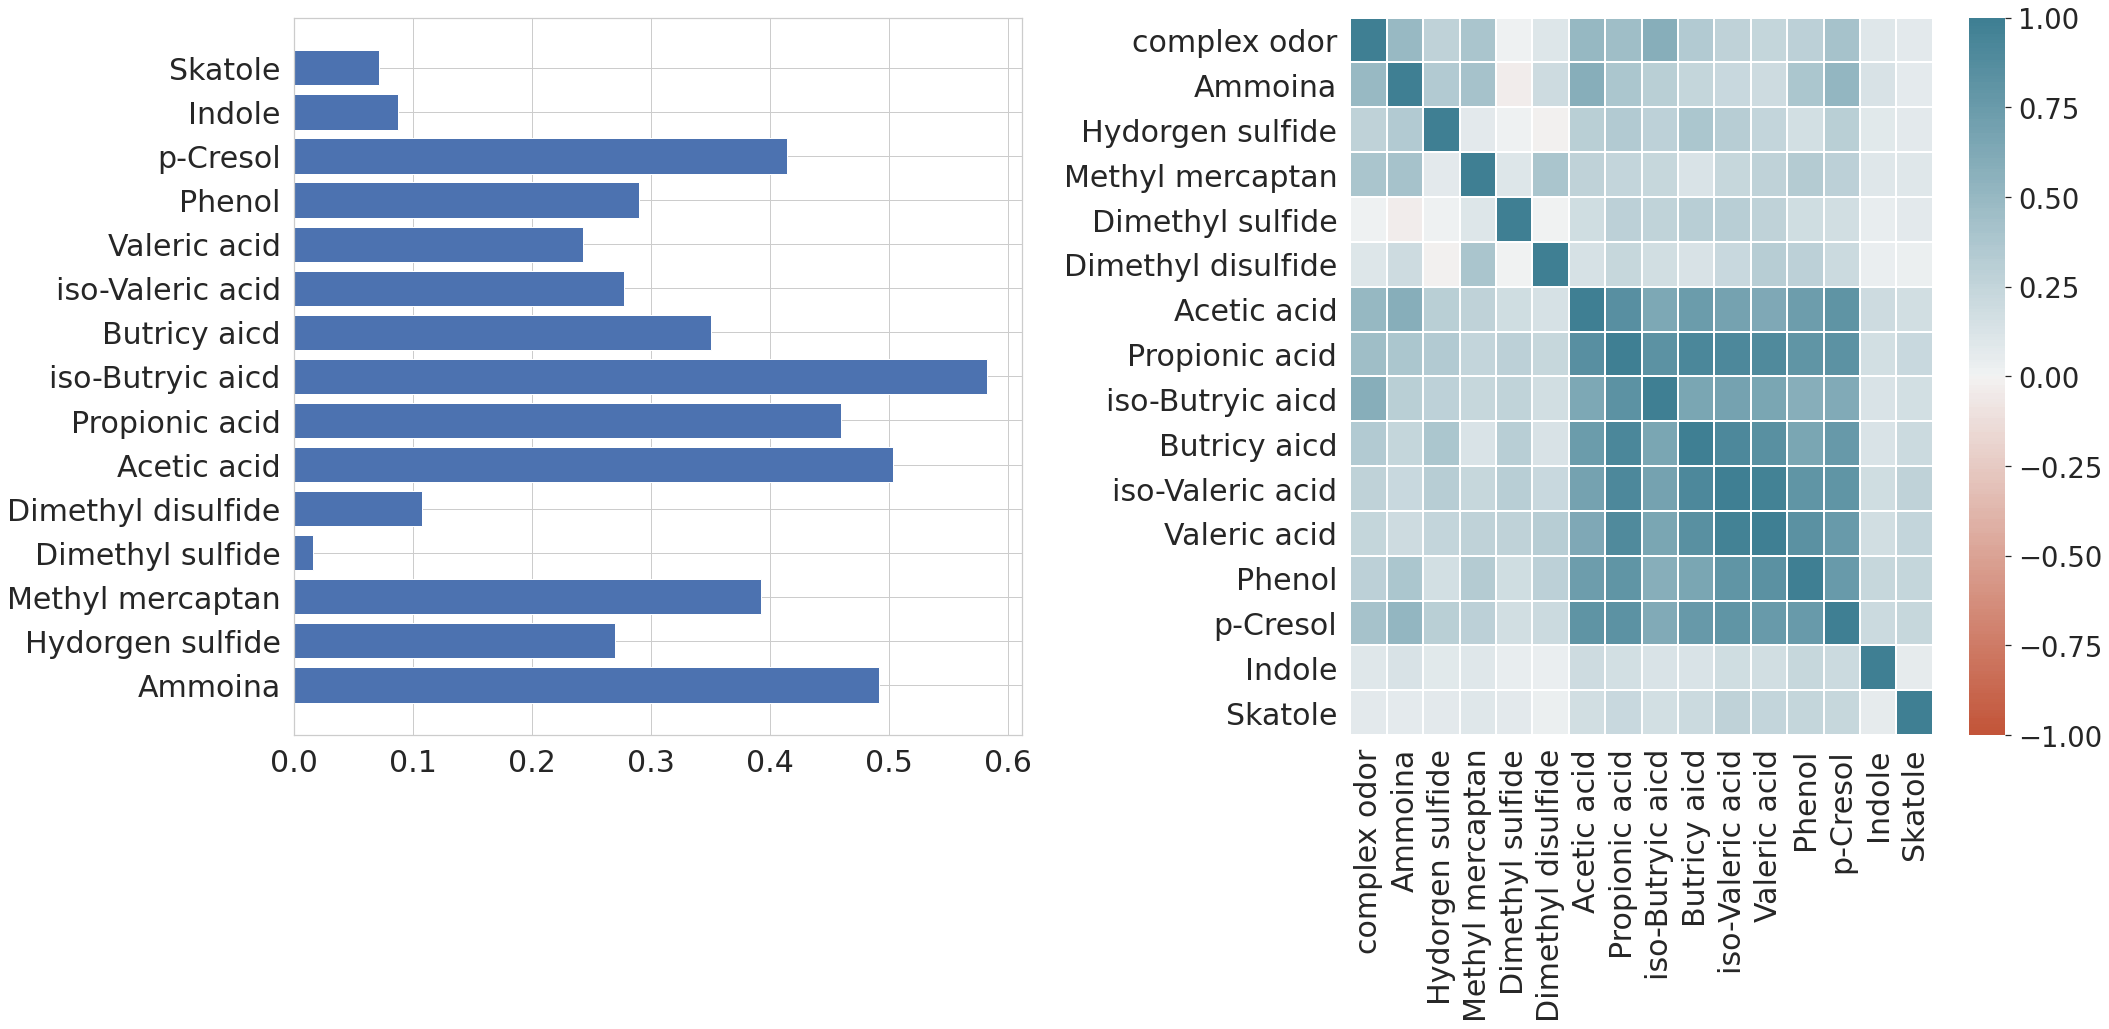

In [42]:
plt.figure(figsize = (30, 15))
sns.set_style("whitegrid")

### Feature correlation
plt.subplot(1, 2, 1)
feature_names = ['Ammoina', 'Hydorgen sulfide', 'Methyl mercaptan', 'Dimethyl sulfide', 'Dimethyl disulfide', 'Acetic acid', 'Propionic acid', 
                 'iso-Butryic aicd', 'Butricy aicd','iso-Valeric acid', 'Valeric acid', 'Phenol', 'p-Cresol', 'Indole', 'Skatole']
X, y = en_data[feature_names], en_data["complex odor"]

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels = features)
visualizer.fit(X, y)      # Fit the data to the visualizer
plt.xticks(fontsize = 30); plt.yticks(fontsize = 30);


### Heatmap
plt.subplot(1, 2, 2)
sns.set(font_scale = 2.5)
en_corr = en_data.drop(columns = ["boundary", "in", "out", "fall", "spring", "summer"]).corr()
sns.heatmap(en_corr, vmin = -1, vmax = 1, center = 0,  # mask = mask,
            cmap = sns.diverging_palette(20, 220, n=200), linewidths = .3, annot = False)
plt.xticks(fontsize = 30) ; plt.yticks(fontsize = 30)


plt.tight_layout()
plt.savefig('odor correlation.png', dpi = 300);

In [30]:
correlation_df = pd.DataFrame(np.round(en_corr["complex odor"][1:], 3))
correlation_df

,complex odor
Ammoina,0.492
Hydorgen sulfide,0.270
Methyl mercaptan,0.393
Dimethyl sulfide,0.016
Dimethyl disulfide,0.107
Acetic acid,0.504
Propionic acid,0.460
iso-Butryic aicd,0.583
Butricy aicd,0.350
iso-Valeric acid,0.277


In [31]:
en_data2 = en_data.copy()
new_colname = []
for i in range(16) :
    x = en_data2.columns[i].replace(" ", "_")
    x = x.replace("-", "_")
    new_colname.append(x)

en_data2.columns = new_colname + list(en_data2.columns[-6:])

formula = "complex_odor ~ " + " + ".join(en_data2.columns[1:-6])
model = ols(formula, en_data2[:-6])
res = model.fit()
vif_df = pd.DataFrame({'Variables': column, 'VIF': np.round(variance_inflation_factor(model.exog, i), 3)} 
                      for i, column in enumerate(model.exog_names)
                      if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

vif_df.index = correlation_df.index
pd.concat([correlation_df, vif_df["VIF"]], axis = 1)

,complex odor,VIF
Ammoina,0.492,2.474
Hydorgen sulfide,0.270,1.419
Methyl mercaptan,0.393,1.530
Dimethyl sulfide,0.016,1.216
Dimethyl disulfide,0.107,1.477
Acetic acid,0.504,8.821
Propionic acid,0.460,58.695
iso-Butryic aicd,0.583,6.347
Butricy aicd,0.350,20.396
iso-Valeric acid,0.277,34.929


In [32]:
correlation_df

,complex odor
Ammoina,0.492
Hydorgen sulfide,0.270
Methyl mercaptan,0.393
Dimethyl sulfide,0.016
Dimethyl disulfide,0.107
Acetic acid,0.504
Propionic acid,0.460
iso-Butryic aicd,0.583
Butricy aicd,0.350
iso-Valeric acid,0.277


# **[ Visualization 1 ]**

## **_boxplot**

### **__1. Total**

In [1]:
# plt.figure(figsize = (18, 5))
# plt.boxplot(en_data.iloc[:, :-6].T)
# plt.xticks(list(range(1,17)), en_data.columns[:-6], rotation = 45, fontsize = 15) 
# plt.yticks(fontsize = 15);

In [164]:
imp_data[imp_data["complex odor"] == 10000]

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,time,spot,farm
174,10000.0,3.43,620.0,20.1,21.30,0.04,426.00,834.0,380.00,1.305,0.54,0.33,0.78,0.42,0.40,0.38,18.08.14,out,송원
208,10000.0,5.00,201.0,11.4,4.76,0.05,1299.45,713.0,55.78,708.530,102.64,204.80,17.17,148.05,2.64,3.73,18.11.06,out,할렐루야1


In [165]:
display(imp_data[imp_data["farm"] == "송원"])
display(imp_data[imp_data["farm"] == "할렐루야1"])

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,time,spot,farm
25,6.0,0.28,0.16,0.07,0.08,0.04,3.55,4.41,1.59,2.620,1.23,0.96,0.85,1.13,0.40,0.38,18.08.14,boundary,송원
47,20.0,0.06,0.13,0.06,0.06,0.05,1.26,0.99,0.83,1.570,1.76,1.05,0.13,0.17,1.29,0.82,18.10.17,boundary,송원
62,14.0,0.19,0.26,0.06,0.06,0.05,0.76,0.18,0.07,0.690,0.67,1.50,0.20,1.15,0.29,0.27,18.10.31,boundary,송원
174,10000.0,3.43,620.00,20.10,21.30,0.04,426.00,834.00,380.00,1.305,0.54,0.33,0.78,0.42,0.40,0.38,18.08.14,out,송원
188,30.0,0.05,9.47,0.06,0.06,0.05,11.39,2.16,1.06,2.040,2.50,1.50,0.31,0.15,2.40,1.07,18.10.17,out,송원
202,66.0,0.20,4.53,0.06,0.06,0.05,0.95,0.37,0.07,1.000,0.75,1.58,0.20,1.15,0.29,0.27,18.10.31,out,송원


,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole,time,spot,farm
19,10.0,0.14,0.04,0.07,0.08,0.04,0.49,1.95,0.93,0.52,0.53,0.49,0.83,0.42,0.40,0.38,18.07.30,boundary,할렐루야1
41,30.0,0.19,2.50,0.06,0.06,0.05,6.30,2.90,1.10,2.70,1.80,1.60,0.30,0.30,1.20,0.70,18.10.10,boundary,할렐루야1
54,30.0,0.30,3.68,0.29,0.06,0.05,6.00,2.20,1.00,2.30,1.70,1.50,0.50,0.30,1.40,1.00,18.10.24,boundary,할렐루야1
68,30.0,0.40,1.25,0.06,0.06,0.05,5.88,2.19,0.94,2.26,1.70,1.43,0.46,0.26,1.37,0.96,18.11.06,boundary,할렐루야1
109,669.0,3.57,673.00,16.40,0.08,0.04,84.20,0.24,0.93,0.52,1.58,5.16,12.20,4.28,0.40,0.38,18.07.30,in,할렐루야1
121,3000.0,7.13,499.00,0.06,0.06,0.05,885.90,637.80,55.00,567.70,87.80,207.80,15.70,99.30,2.30,1.20,18.10.10,in,할렐루야1
125,6694.0,10.30,136.00,12.20,6.23,0.05,1366.90,799.40,58.40,784.30,110.90,229.00,16.30,141.90,2.80,4.40,18.10.24,in,할렐루야1
130,4481.0,6.20,50.30,0.06,0.06,0.05,1344.23,786.11,63.37,771.33,109.05,225.19,16.00,139.52,3.43,4.34,18.11.06,in,할렐루야1
167,448.0,8.05,125.00,0.07,0.08,0.04,92.00,0.26,0.93,0.52,1.60,4.69,1.63,5.19,0.40,0.38,18.07.30,out,할렐루야1
184,669.0,1.38,237.00,0.06,0.06,0.05,823.30,556.50,47.00,491.50,76.60,191.80,10.90,69.00,1.90,1.50,18.10.10,out,할렐루야1


### **__2. Categorical**

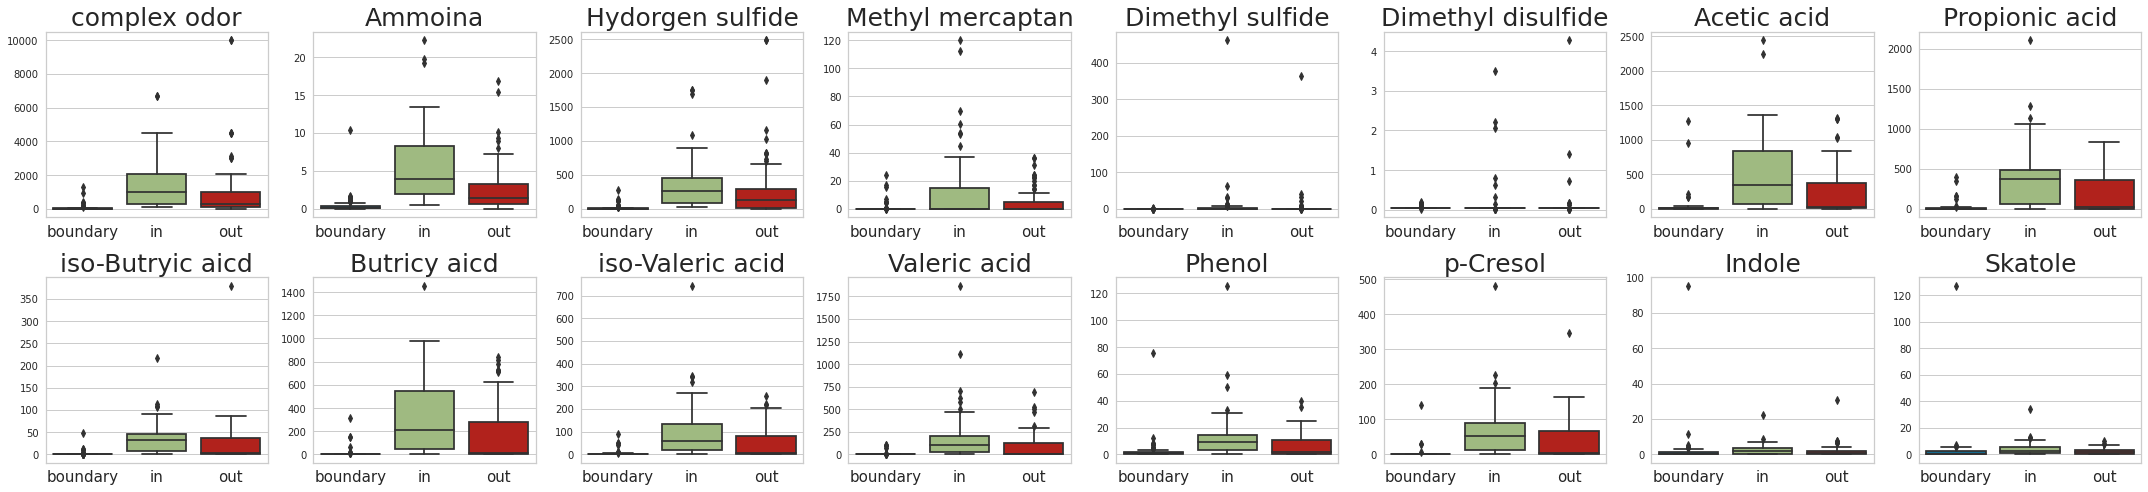

In [166]:
### Spot 별 boxplot
plt.figure(figsize = (30, 7))
for i in range(0, 16) :
    plt.subplot(2, 8, i+1)
    sns.boxplot(x = "spot", y = imp_data.columns[i], data = imp_data)
    plt.xlabel("") ; plt.ylabel("")
    plt.title(imp_data.columns[i], fontsize = 25)
    plt.xticks(fontsize = 15)
    
plt.tight_layout();

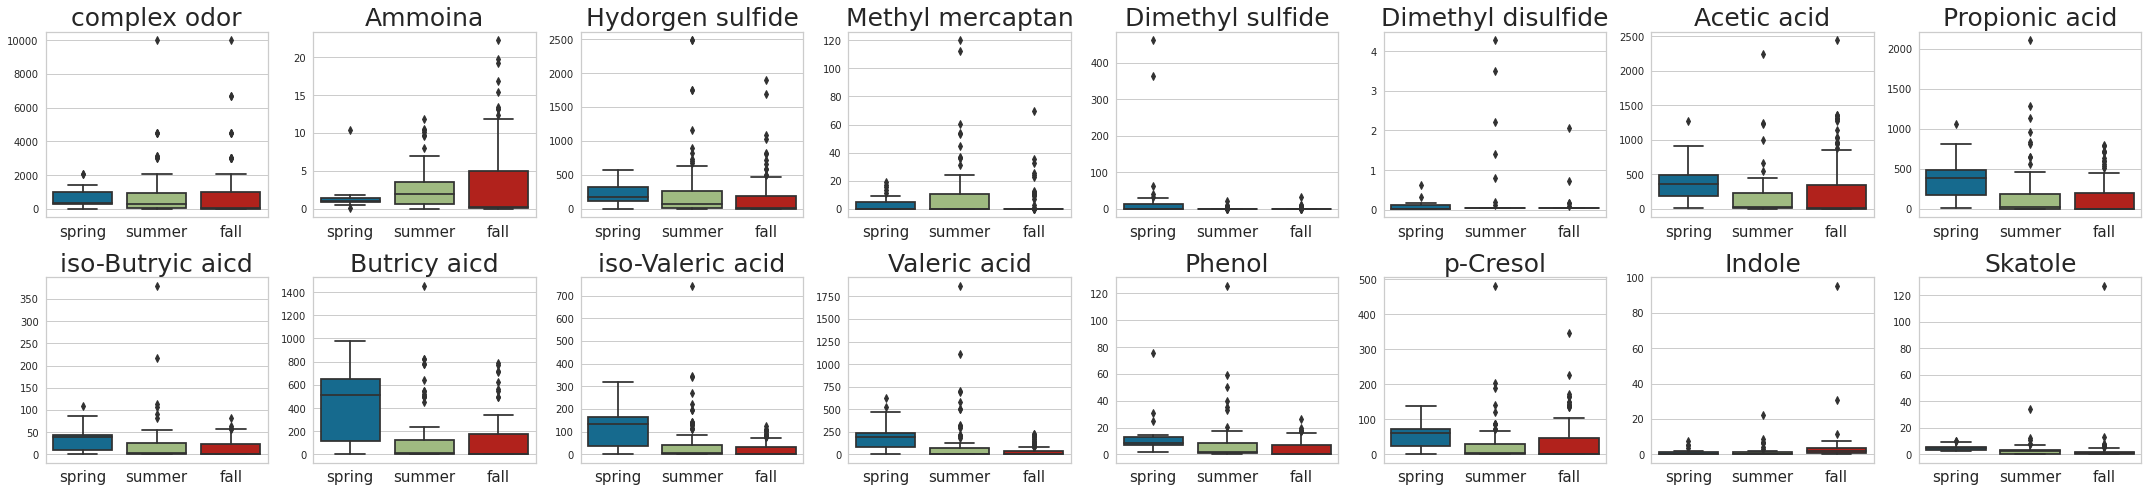

In [167]:
### season 별 boxplot
temp_data = imp_data.copy()
temp_data["Month"] = [temp_data.loc[i, "time"][3:5] for i in range(temp_data.shape[0])]
x = temp_data["Month"].astype("int")
condlist = [((x >= 3) & (x <= 5)), ((x >= 6) & (x <= 8)), ((x >= 9) & (x <= 11))]
choicelist = ["spring", "summer", "fall"]
temp_data["season"] = np.select(condlist, choicelist, "winter")
temp_data.drop(columns = ["Month", "time"], inplace = True)

plt.figure(figsize = (30, 7))
for i in range(0, 16) :
    plt.subplot(2, 8, i+1)
    sns.boxplot(x = "season", y = temp_data.columns[i], data = temp_data)
    plt.xlabel("") ; plt.ylabel("")
    plt.title(temp_data.columns[i], fontsize = 25)
    plt.xticks(fontsize = 15)
    
plt.tight_layout();

## **_bar plot**

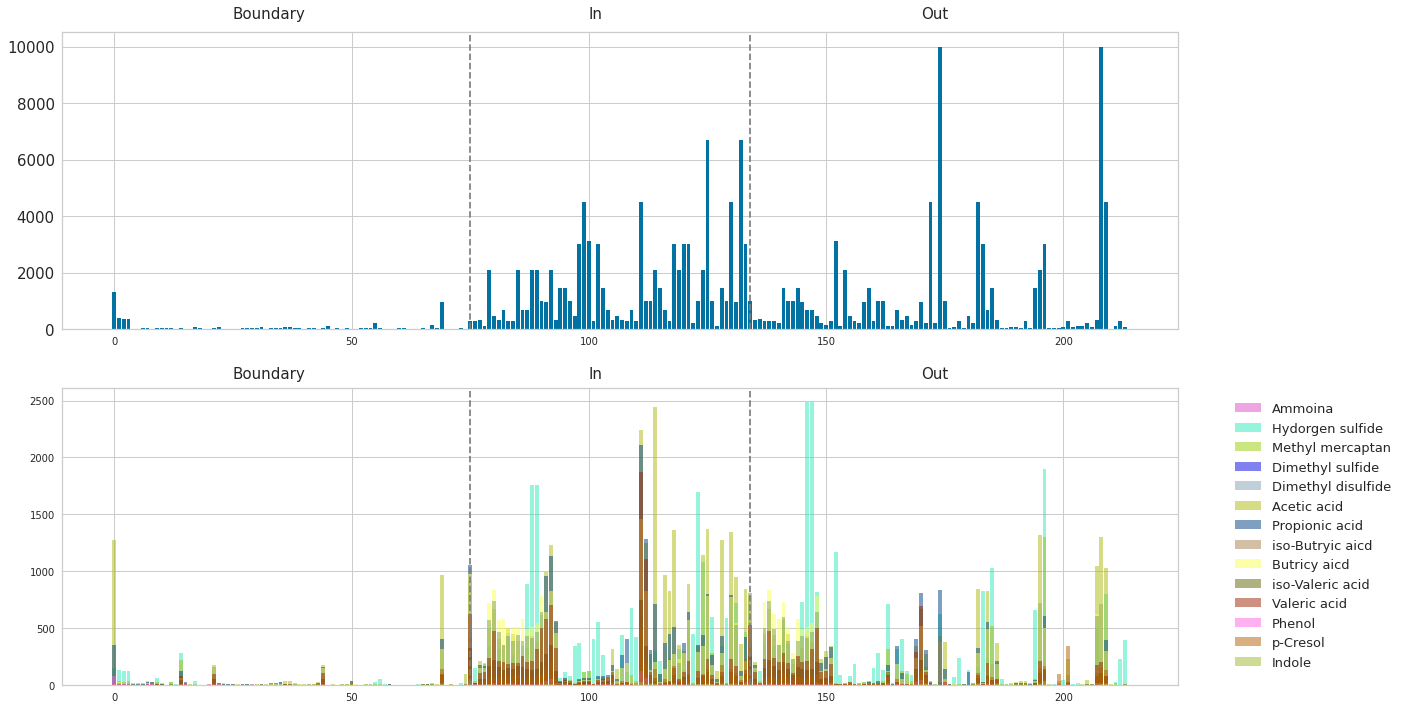

In [168]:
np.random.seed(29)
color_ = list(mcolors.XKCD_COLORS.keys())
colors = np.random.choice(color_, replace = False, size = 15)

plt.figure(figsize = (20, 12))
plt.subplot(2,1,1)
plt.bar(x = en_data.index, height = en_data["complex odor"])
plt.axvline(en_data["boundary"].sum(), color = "gray", linestyle = "--")
plt.axvline(en_data["boundary"].sum() + en_data["in"].sum(), color = "gray", linestyle = "--")
plt.yticks(fontsize = 15)
plt.text(25, 11000, "Boundary", fontsize = 15) ; plt.text(100, 11000, "In", fontsize = 15) ;  plt.text(170, 11000, "Out", fontsize = 15)

plt.subplot(2,1,2)
for i in range(1, 15) : 
    plt.bar(x = en_data.index, height = en_data.iloc[:, i], color = colors[i], alpha = 0.5)
    
plt.legend(labels = en_data.columns[1:15], loc = (1.04 , 0.01), borderpad = 1, fontsize = 13)
plt.axvline(en_data["boundary"].sum(), color = "gray", linestyle = "--")
plt.axvline(en_data["boundary"].sum() + en_data["in"].sum(), color = "gray", linestyle = "--")
plt.text(25, 2700, "Boundary", fontsize = 15) ; plt.text(100, 2700, "In", fontsize = 15) ;  plt.text(170, 2700, "Out", fontsize = 15);

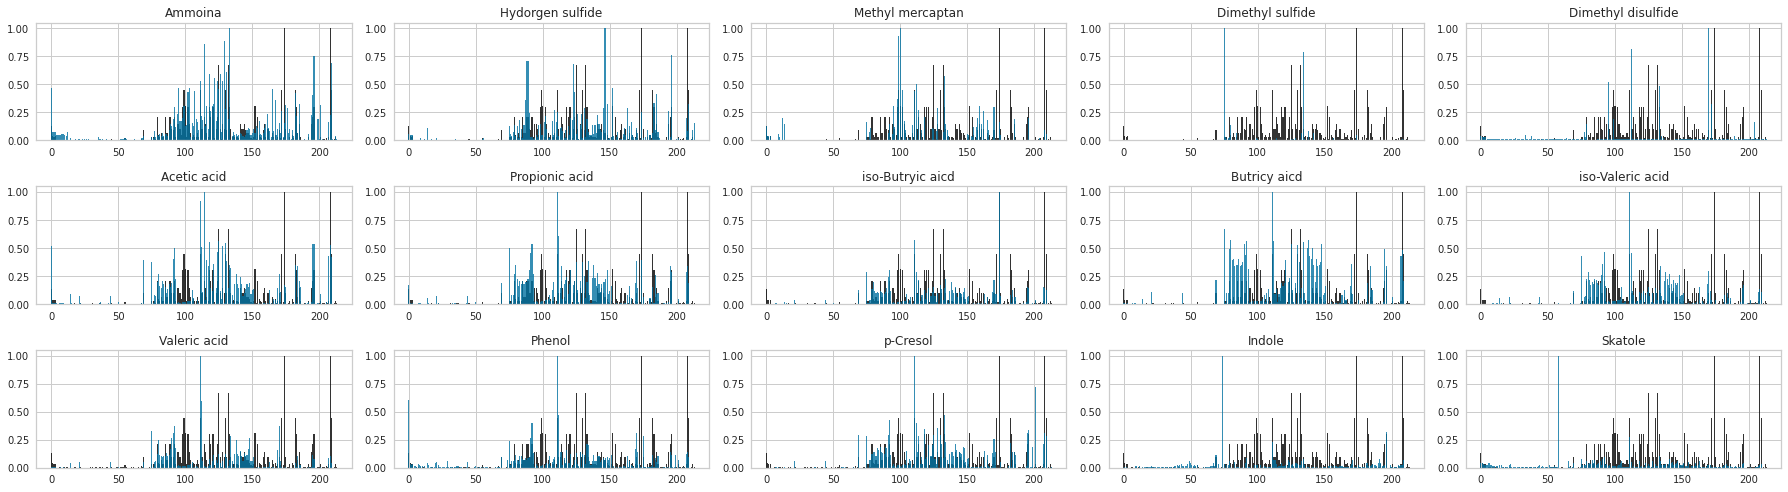

In [169]:
plt.figure(figsize = (25, 7))

for i in range(1, 16) : 
    plt.subplot(3,5,i)
    plt.bar(x = en_data.index, height = en_data["complex odor"]/en_data["complex odor"].max(), color = "black", alpha = 0.8)
    plt.bar(x = en_data.index, height = en_data.iloc[:,i].astype(float)/en_data.iloc[:,i].astype(float).max(), alpha = 0.8)
    plt.title(en_data.columns[i])
plt.tight_layout()

# **[ Preprocessing 2 ]**

## **_Outlier**

In [170]:
### complex odor값이 9000보다 큰 값은 제거.
outlier = en_data[en_data["complex odor"] > 9000]
pre_data = en_data.drop(index = outlier.index).reset_index(drop = True)
print(en_data.shape, pre_data.shape)
pre_data.head(3)

(214, 22) (212, 22)


,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,Phenol,p-Cresol,Indole,Skatole,boundary,in,out,fall,spring,summer
0,1314.204414,10.374437,149.737225,15.883465,0.0,0.166644,1272.659247,354.403061,0.155839,10.136117,...,75.619672,0.050000,0.050000,5.045635,1,0,0,0,1,0
1,398.443371,1.605300,127.205918,4.587934,0.0,0.116850,34.234155,15.955100,2.024014,20.602569,...,4.145208,1.142263,0.848513,4.960978,1,0,0,0,1,0
2,350.245307,1.618517,118.306453,4.675428,0.0,0.117278,22.928672,7.228658,0.951650,5.772918,...,3.251023,0.980568,0.495689,4.801511,1,0,0,0,1,0


## **_Anova**

In [171]:
### Spot별 ANOVA
features, f_values, p_values = [], [], []
in_means, out_means, boundary_means = [], [], []
spot_sig_var = []

for i in range(0, 16) :
    data1 = pre_data[pre_data["boundary"] == 1][pre_data.columns[i]]
    data2 = pre_data[pre_data["in"] == 1][pre_data.columns[i]]
    data3 = pre_data[pre_data["out"] == 1][pre_data.columns[i]]

    f_value, p_value = stats.f_oneway(data1, data2, data3)
    
    if p_value < 0.05 :
        spot_sig_var.append(pre_data.columns[i])
    
    boundary_means.append(np.round(data1.mean(), 3))
    in_means.append(np.round(data2.mean(), 3))
    out_means.append(np.round(data3.mean(), 3))
    features.append(pre_data.columns[i])
    f_values.append(f_value)
    p_values.append(p_value)

spot_anova = pd.DataFrame([features, in_means, out_means, boundary_means, f_values, p_values], index = ["features", "mean of in", "mean of out", "mean of boundary","f-value", "p-value"]).T
display(spot_anova)
print(spot_sig_var)

,features,mean of in,mean of out,mean of boundary,f-value,p-value
0,complex odor,1533.05,708.6,73.523,33.8443,1.85012e-13
1,Ammoina,5.737,2.542,0.49,38.5156,5.75553e-15
2,Hydorgen sulfide,357.28,275.628,16.273,16.9522,1.50417e-07
3,Methyl mercaptan,14.257,4.241,1.177,13.9047,2.14097e-06
4,Dimethyl sulfide,11.868,6.076,0.105,1.39504,0.250122
5,Dimethyl disulfide,0.2,0.127,0.055,1.82432,0.163887
6,Acetic acid,495.784,218.761,45.745,25.4808,1.25108e-10
7,Propionic acid,380.366,177.015,21.231,33.9087,1.76223e-13
8,iso-Butryic aicd,36.228,17.959,2.01,33.1611,3.10373e-13
9,Butricy aicd,323.145,173.779,11.947,30.4768,2.42974e-12


['complex odor', 'Ammoina', 'Hydorgen sulfide', 'Methyl mercaptan', 'Acetic acid', 'Propionic acid', 'iso-Butryic aicd', 'Butricy aicd', 'iso-Valeric acid', 'Valeric acid', 'Phenol', 'p-Cresol']


In [172]:
group = (en_data["in"]*1) + (en_data["out"]*2) + (en_data["boundary"]*3)

for i in range(len(spot_sig_var)) :
    print("{}에 대한 사후 검정".format(spot_sig_var[i]))
    posthoc = pairwise_tukeyhsd(en_data[spot_sig_var[i]], group, alpha=0.05)
    print(posthoc)
    print("=======================================================\n")

complex odor에 대한 사후 검정
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     1      2  -592.1659 0.0305 -1139.7453  -44.5866   True
     1      3 -1459.5279  0.001 -2014.8007 -904.2551   True
     2      3   -867.362  0.001 -1380.2244 -354.4995   True
-----------------------------------------------------------

Ammoina에 대한 사후 검정
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -3.1529 0.001 -4.5422 -1.7636   True
     1      3  -5.2466 0.001 -6.6554 -3.8378   True
     2      3  -2.0937 0.001 -3.3949 -0.7925   True
---------------------------------------------------

Hydorgen sulfide에 대한 사후 검정
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
------------------------------

In [173]:
### Season별 ANOVA
features, f_values, p_values = [], [], []
spring_means, summer_means, fall_means = [], [], []
season_sig_var = []

for i in range(0, 16) :
    data1 = pre_data[pre_data["spring"] == 1][pre_data.columns[i]]
    data2 = pre_data[pre_data["summer"] == 1][pre_data.columns[i]]
    data3 = pre_data[pre_data["fall"] == 1][pre_data.columns[i]]

    f_value, p_value = stats.f_oneway(data1, data2, data3)
    if p_value < 0.05 :
        season_sig_var.append(pre_data.columns[i])
    
    spring_means.append(np.round(data1.mean(), 3))
    summer_means.append(np.round(data2.mean(), 3))
    fall_means.append(np.round(data3.mean(), 3))
    features.append(pre_data.columns[i])
    f_values.append(f_value)
    p_values.append(p_value)

season_anova = pd.DataFrame([features, spring_means, summer_means, fall_means, f_values, p_values], index = ["features", "mean of spring", "mean of summer", "mean of fall", "f-value", "p-value"]).T
display(season_anova)
print(season_sig_var)

,features,mean of spring,mean of summer,mean of fall,f-value,p-value
0,complex odor,641.822,681.108,768.363,0.187612,0.829076
1,Ammoina,1.438,2.602,3.2,2.14734,0.119364
2,Hydorgen sulfide,213.678,240.98,169.284,0.79006,0.455168
3,Methyl mercaptan,3.808,9.391,3.079,4.20654,0.0161784
4,Dimethyl sulfide,37.241,0.682,0.833,10.6677,3.87776e-05
5,Dimethyl disulfide,0.084,0.171,0.083,1.05951,0.348481
6,Acetic acid,377.45,157.855,269.192,3.88304,0.0220899
7,Propionic acid,365.326,167.306,132.446,7.62251,0.0006379
8,iso-Butryic aicd,35.101,16.439,12.938,7.43417,0.000760417
9,Butricy aicd,428.163,130.032,103.678,20.9204,5.22598e-09


['Methyl mercaptan', 'Dimethyl sulfide', 'Acetic acid', 'Propionic acid', 'iso-Butryic aicd', 'Butricy aicd', 'iso-Valeric acid', 'Valeric acid', 'Phenol']


In [174]:
group = (en_data["spring"]*1) + (en_data["summer"]*2) + (en_data["fall"]*3)

for i in range(len(season_sig_var)) :
    print("{}에 대한 사후 검정".format(season_sig_var[i]))
    posthoc = pairwise_tukeyhsd(en_data[season_sig_var[i]], group, alpha=0.05)
    print(posthoc)
    print("=======================================================\n")

Methyl mercaptan에 대한 사후 검정
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   5.6972 0.1966   -2.076 13.4705  False
     1      3  -0.6382    0.9  -8.4308  7.1544  False
     2      3  -6.3354 0.0143 -11.6304 -1.0404   True
-----------------------------------------------------

Dimethyl sulfide에 대한 사후 검정
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     1      2 -36.3401 0.001 -56.0489 -16.6313   True
     1      3 -36.3651 0.001  -56.123 -16.6072   True
     2      3   -0.025   0.9 -13.4502  13.4002  False
-----------------------------------------------------

Acetic acid에 대한 사후 검정
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
----------------------------------------------------

In [175]:
### 측정일  ->  월(month)만 사용, 문자열로 저장
en_data2 = imp_data.copy()

en_data2["Month"] = [en_data2.loc[i, "time"][3:5] for i in range(en_data2.shape[0])]
en_data2.drop(columns = "time", inplace = True)


### 12개월  ->  4분기
condlist = [((x == 3) | (x == 4))]
choicelist = ["spring"]
en_data2["season"] = np.select(condlist, choicelist, "summer")
en_data2.drop(columns = "Month", inplace = True)


### season  ->  One-Hot Encoding
encode_season = pd.get_dummies(en_data2["season"])
en_data2 = pd.concat([en_data2.drop(columns = "season"), encode_season], axis = 1)
en_data2.head(3)


### Season별 ANOVA
features, f_values, p_values = [], [], []
spring_means, summer_means = [], []
season_sig_var = []

for i in range(0, 16) :
    data1 = en_data2[en_data2["spring"] == 1][en_data2.columns[i]]
    data2 = en_data2[en_data2["summer"] == 1][en_data2.columns[i]]

    f_value, p_value = stats.f_oneway(data1, data2)
    if p_value < 0.05 :
        season_sig_var.append(en_data2.columns[i])
    
    spring_means.append(np.round(data1.mean(), 3))
    summer_means.append(np.round(data2.mean(), 3))
    features.append(en_data2.columns[i])
    f_values.append(f_value)
    p_values.append(p_value)

season_anova = pd.DataFrame([features, spring_means, summer_means, f_values, p_values], index = ["features", "mean of spring", "mean of summer", "f-value", "p-value"]).T
display(season_anova)
print(season_sig_var)

,features,mean of spring,mean of summer,f-value,p-value
0,complex odor,728.551,801.528,0.00966753,0.921768
1,Ammoina,2.916,2.715,0.00989461,0.920858
2,Hydorgen sulfide,198.684,208.692,0.00261291,0.959281
3,Methyl mercaptan,13.168,5.9,0.858873,0.355108
4,Dimethyl sulfide,209.7,1.758,200.162,1.93802e-32
5,Dimethyl disulfide,0.079,0.122,0.0369097,0.847833
6,Acetic acid,750.859,230.798,6.54689,0.0112039
7,Propionic acid,559.496,176.905,6.95232,0.00899066
8,iso-Butryic aicd,49.495,18.699,2.7294,0.0999963
9,Butricy aicd,452.439,154.364,5.179,0.0238608


['Dimethyl sulfide', 'Acetic acid', 'Propionic acid', 'Butricy aicd', 'iso-Valeric acid', 'Valeric acid', 'Phenol']


# **[ Visualization 2 ]**

## **_boxplot**

### **__1. Total**

In [179]:
pre_data

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,Phenol,p-Cresol,Indole,Skatole,boundary,in,out,fall,spring,summer
0,1314.204414,10.374437,149.737225,15.883465,0.00,0.166644,1272.659247,354.403061,0.155839,10.136117,...,75.619672,0.050000,0.050000,5.045635,1,0,0,0,1,0
1,398.443371,1.605300,127.205918,4.587934,0.00,0.116850,34.234155,15.955100,2.024014,20.602569,...,4.145208,1.142263,0.848513,4.960978,1,0,0,0,1,0
2,350.245307,1.618517,118.306453,4.675428,0.00,0.117278,22.928672,7.228658,0.951650,5.772918,...,3.251023,0.980568,0.495689,4.801511,1,0,0,0,1,0
3,369.329538,1.621378,122.894983,4.625260,0.00,0.118621,30.939140,11.723489,1.293944,14.243849,...,4.624998,1.041485,0.050000,2.684469,1,0,0,0,1,0
4,10.000000,1.051810,0.250000,0.070000,0.07,0.020000,17.534394,6.671902,1.246475,1.492030,...,1.615309,0.858109,0.050000,2.611138,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4481.000000,15.440000,802.000000,6.870000,0.06,0.050000,1030.540000,396.310000,47.950000,295.270000,...,12.230000,134.480000,6.340000,4.490000,0,0,1,1,0,0
208,5.000000,0.190000,0.060000,0.060000,0.06,0.050000,3.400000,1.250000,0.110000,1.030000,...,0.280000,0.200000,0.070000,0.100000,0,0,1,1,0,0
209,100.000000,0.160000,22.000000,0.060000,0.06,0.050000,13.010000,1.720000,0.110000,1.360000,...,0.280000,0.200000,0.070000,0.100000,0,0,1,1,0,0
210,300.000000,0.950000,228.000000,0.060000,0.06,0.050000,1.010000,0.230000,0.110000,0.750000,...,0.280000,0.200000,0.070000,0.100000,0,0,1,1,0,0


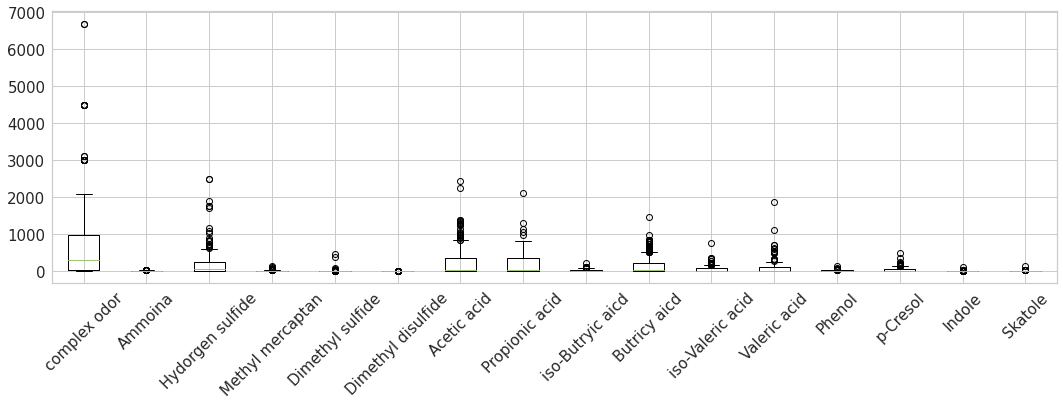

In [181]:
plt.figure(figsize = (18, 5))
plt.boxplot(pre_data.iloc[:, :-6])
plt.xticks(list(range(1,17)), en_data.columns[:-6], rotation = 45, fontsize = 15) 
plt.yticks(fontsize = 15);

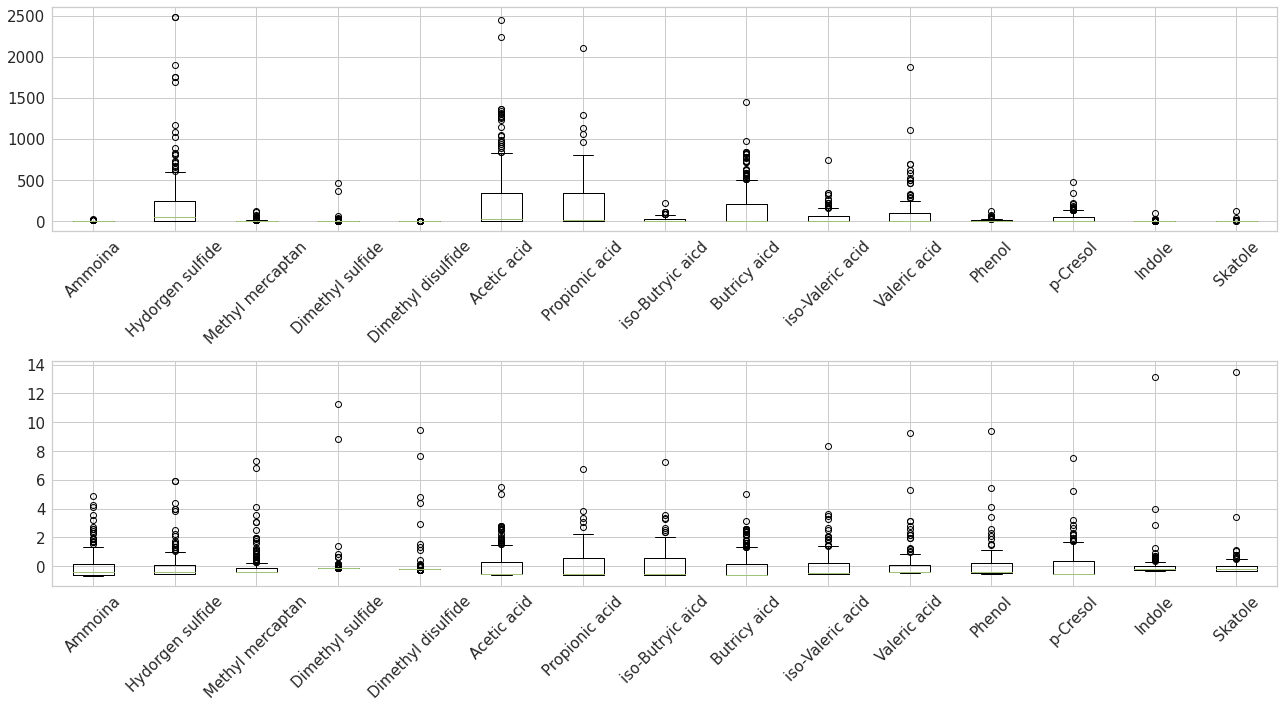

In [195]:
plt.figure(figsize = (18, 10))

plt.subplot(2,1,1)
plt.boxplot(pre_data.iloc[:, 1:-6])
plt.xticks(list(range(1,16)), en_data.columns[1:-6], rotation = 45, fontsize = 15) 
plt.yticks(fontsize = 15)

plt.subplot(2,1,2)
plt.boxplot(StandardScaler().fit_transform(pre_data.iloc[:, 1:-6]))
plt.xticks(list(range(1,16)), en_data.columns[1:-6], rotation = 45, fontsize = 15) 
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.show();

### **__2. Categorical**

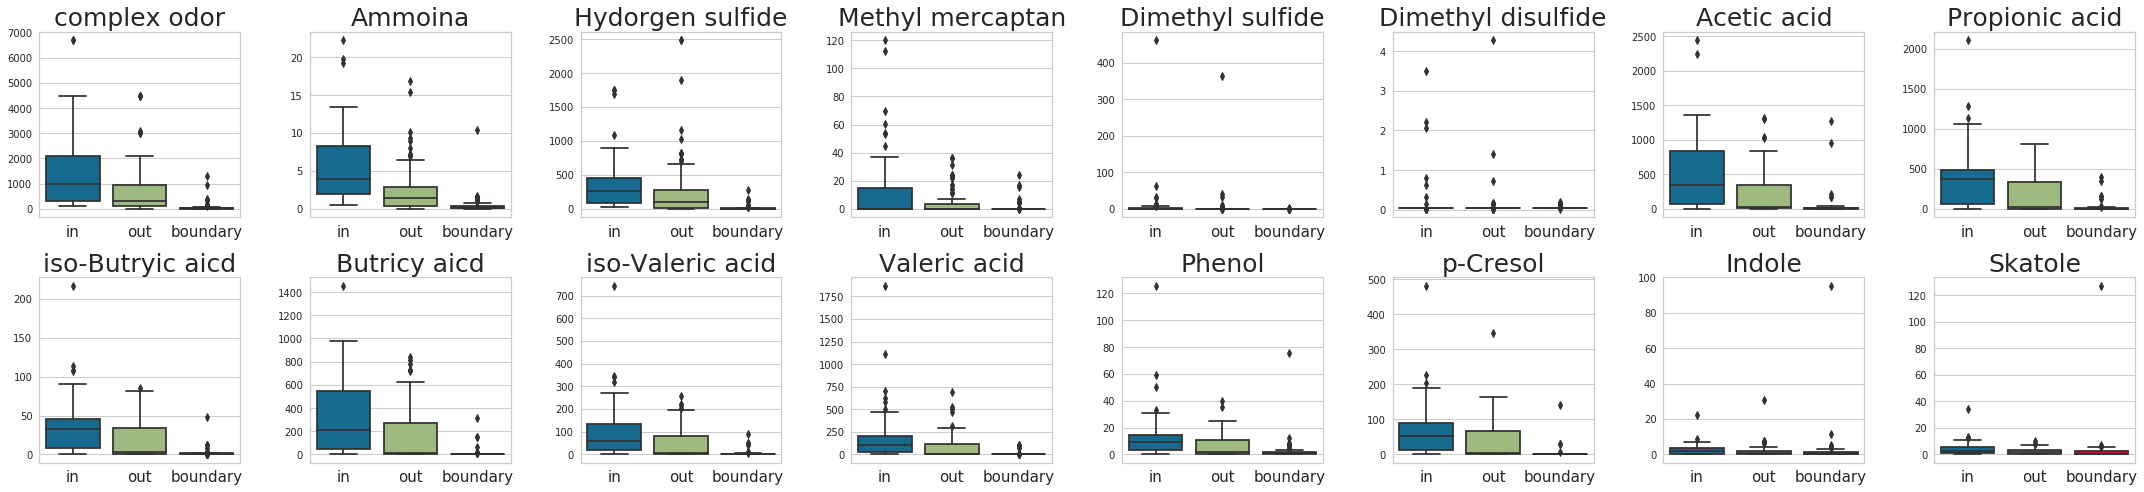

In [157]:
### Spot 별 boxplot
pre_data2 = pre_data.copy()
pre_data2["spot"] = (en_data["in"]*1) + (en_data["out"]*2) + (en_data["boundary"]*3)

plt.figure(figsize = (30, 7))
for i in range(0, 16) :
    plt.subplot(2, 8, i+1)
    sns.boxplot(x = "spot", y = pre_data2.columns[i], data = pre_data2)
    plt.xlabel("") ; plt.ylabel("")
    plt.title(pre_data2.columns[i], fontsize = 25)
    plt.xticks([0, 1, 2], ["in", "out", "boundary"], fontsize = 15)
    
plt.tight_layout();

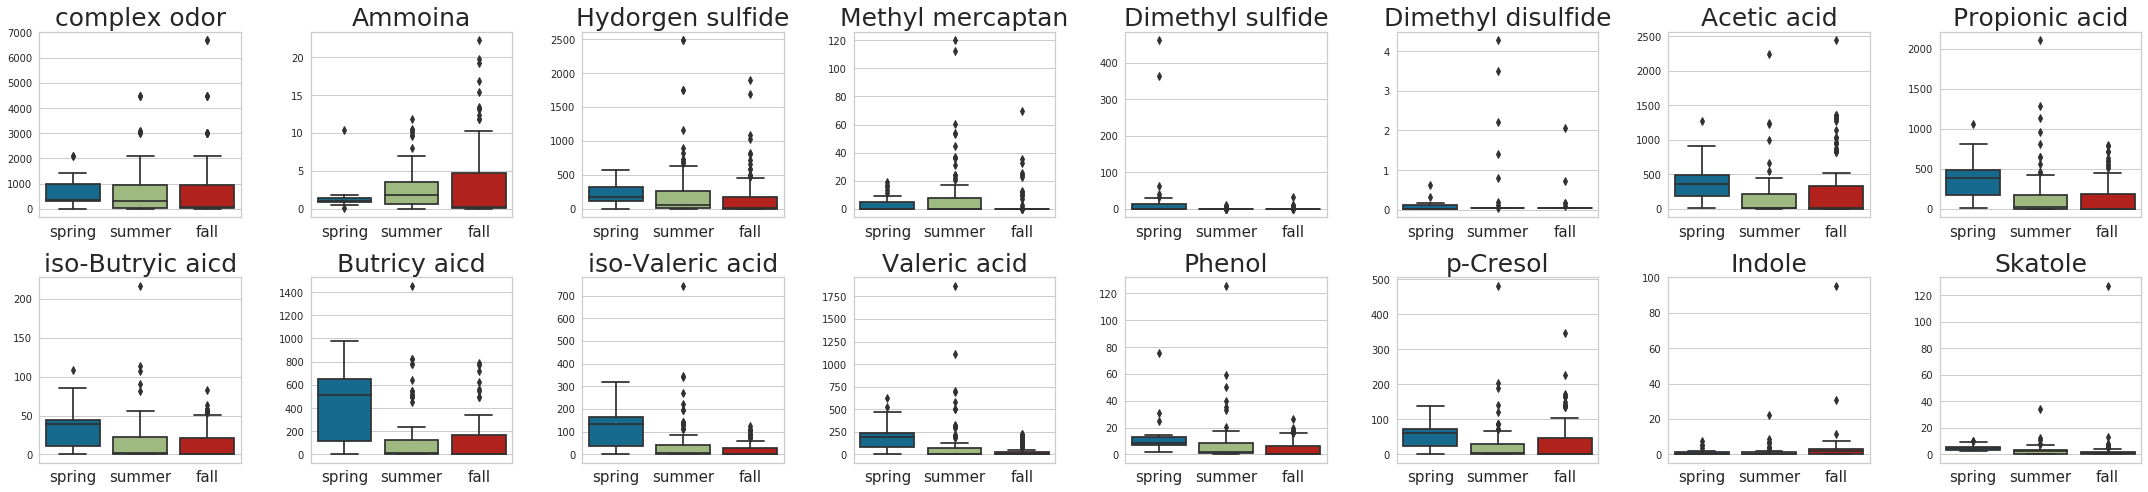

In [156]:
### season 별 boxplot
pre_data2 = pre_data.copy()
pre_data2["season"] = (en_data["spring"]*1) + (en_data["summer"]*2) + (en_data["fall"]*3)

plt.figure(figsize = (30, 7))
for i in range(0, 16) :
    plt.subplot(2, 8, i+1)
    sns.boxplot(x = "season", y = pre_data2.columns[i], data = pre_data2)
    plt.xlabel("") ; plt.ylabel("")
    plt.title(pre_data2.columns[i], fontsize = 25)
    plt.xticks([0, 1, 2], ["spring", "summer", "fall"], fontsize = 15)
    
plt.tight_layout();

## **_bar plot**

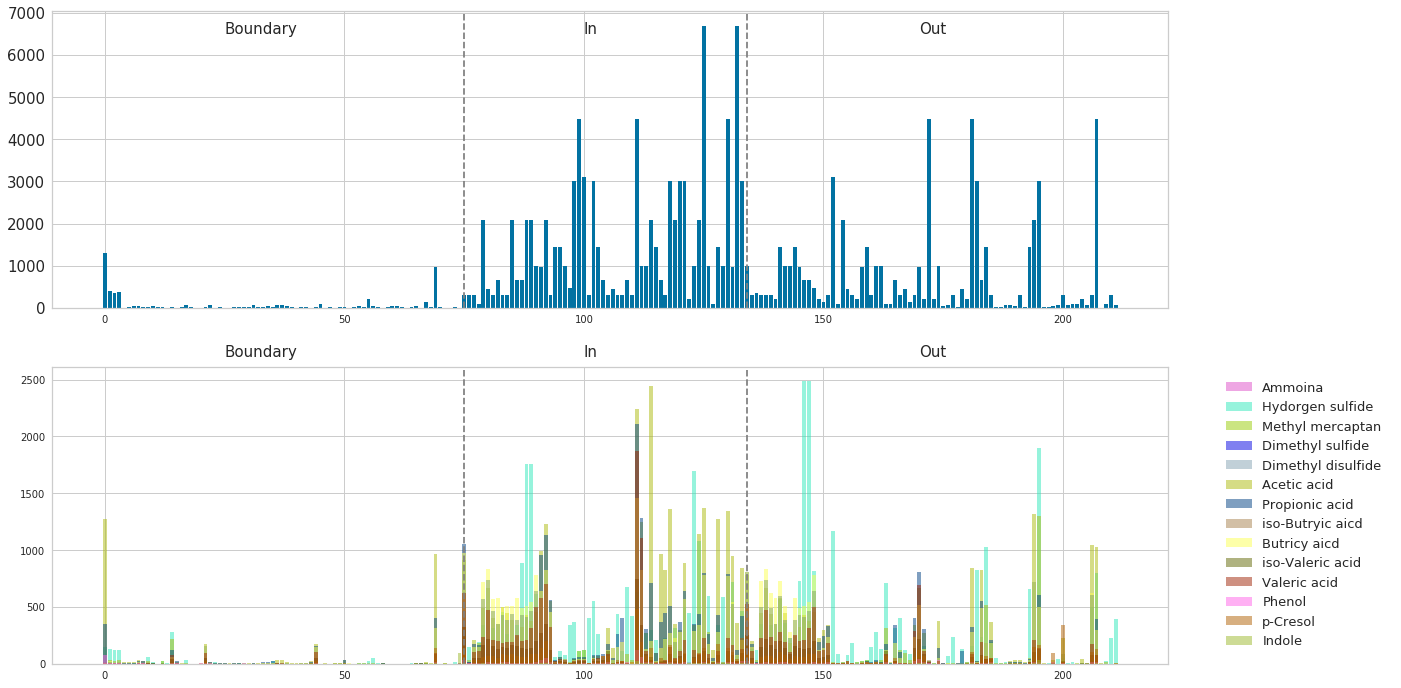

In [161]:
np.random.seed(29)
color_ = list(mcolors.XKCD_COLORS.keys())
colors = np.random.choice(color_, replace = False, size = 15)

plt.figure(figsize = (20, 12))
plt.subplot(2,1,1)
plt.bar(x = pre_data.index, height = pre_data["complex odor"])
plt.axvline(pre_data["boundary"].sum(), color = "gray", linestyle = "--")
plt.axvline(pre_data["boundary"].sum() + pre_data["in"].sum(), color = "gray", linestyle = "--")
plt.yticks(fontsize = 15)
plt.text(25, 6500, "Boundary", fontsize = 15) ; plt.text(100, 6500, "In", fontsize = 15) ;  plt.text(170, 6500, "Out", fontsize = 15)

plt.subplot(2,1,2)
for i in range(1, 15) : 
    plt.bar(x = pre_data.index, height = pre_data.iloc[:, i], color = colors[i], alpha = 0.5)
    
plt.legend(labels = pre_data.columns[1:15], loc = (1.04 , 0.01), borderpad = 1, fontsize = 13)
plt.axvline(pre_data["boundary"].sum(), color = "gray", linestyle = "--")
plt.axvline(pre_data["boundary"].sum() + pre_data["in"].sum(), color = "gray", linestyle = "--")
plt.text(25, 2700, "Boundary", fontsize = 15) ; plt.text(100, 2700, "In", fontsize = 15) ;  plt.text(170, 2700, "Out", fontsize = 15);

In [163]:
# plt.figure(figsize = (25, 7))

# for i in range(1, 16) : 
#     plt.subplot(3,5,i)
#     plt.bar(x = pre_data.index, height = pre_data["complex odor"]/en_data["complex odor"].max(), color = "black", alpha = 0.8)
#     plt.bar(x = pre_data.index, height = pre_data.iloc[:,i].astype(float)/pre_data.iloc[:,i].astype(float).max(), alpha = 0.8)
#     plt.title(pre_data.columns[i])
# plt.tight_layout()

## **_Correlation**

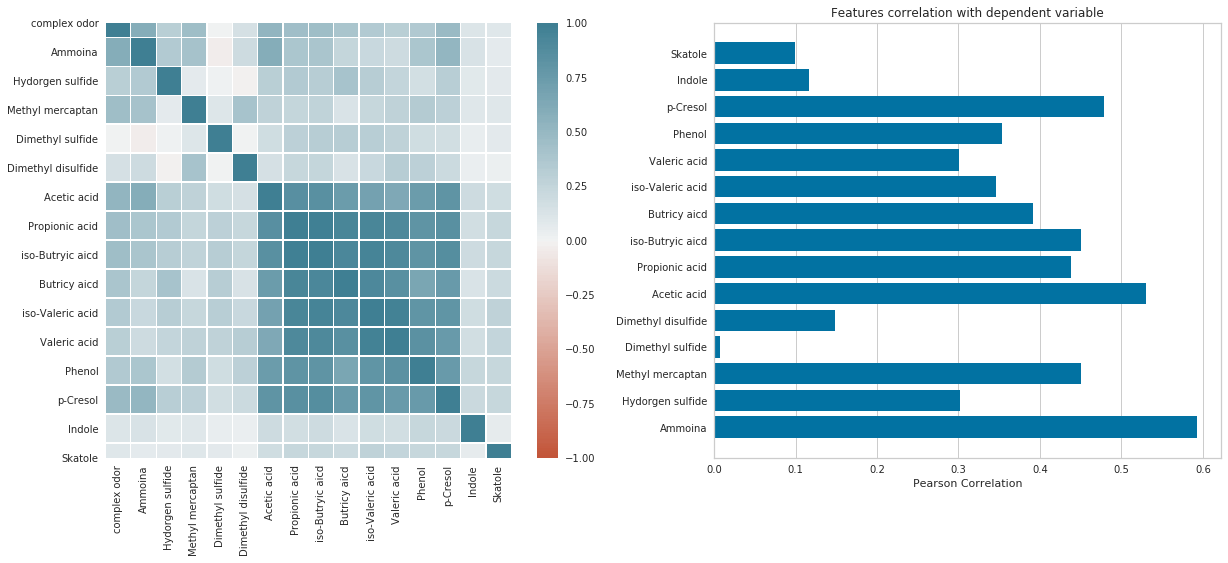

In [166]:
plt.figure(figsize = (20, 8))

### Heatmap
plt.subplot(1, 2, 1)
pre_corr = pre_data.drop(columns = ["boundary", "in", "out", "fall", "spring", "summer"]).corr()
sns.heatmap(pre_corr, vmin = -1, vmax = 1, center = 0,  # mask = mask,
            cmap = sns.diverging_palette(20, 220, n=200), linewidths = .3, annot = False);


### Feature correlation
plt.subplot(1, 2, 2)
feature_names = ['Ammoina', 'Hydorgen sulfide', 'Methyl mercaptan', 'Dimethyl sulfide', 'Dimethyl disulfide', 'Acetic acid', 'Propionic acid', 
                 'iso-Butryic aicd', 'Butricy aicd','iso-Valeric acid', 'Valeric acid', 'Phenol', 'p-Cresol', 'Indole', 'Skatole']
X, y = pre_data[feature_names], pre_data["complex odor"]

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels = features)
visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.show();

In [318]:
# pre_data.to_csv("../DAT/preprocessed data.csv", index = False, header = True)

# **[ Modeling ]**

## **_Train Test split**

In [92]:
X = pre_data.drop(["complex odor"], axis = 1)
y = pre_data["complex odor"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 999)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(169, 21) (43, 21) (169,) (43,)


In [59]:
X_std = StandardScaler().fit(train_X)
train_X_std = pd.DataFrame(X_std.transform(train_X), columns = train_X.columns)
test_X_std = pd.DataFrame(X_std.transform(test_X), columns = test_X.columns)

In [60]:
model_ex = ExtraTreesRegressor(random_state = 999).fit(train_X_std, np.ravel(train_y))
pred_ex = model_ex.predict(test_X_std)

In [61]:
model_rf = RandomForestRegressor(random_state = 999).fit(train_X_std, np.ravel(train_y))
pred_rf = model_rf.predict(test_X_std)

In [62]:
model_xg = XGBRegressor(random_state = 999).fit(train_X_std, np.ravel(train_y))
pred_xg = model_xg.predict(test_X_std)

In [251]:
def R2(true, pred) :
  sse = ((np.array(true) - np.array(pred))**2).sum()
  ssr = ((np.array(pred) - np.mean(true))**2).sum()
  sst = ((np.array(true) - np.mean(true))**2).sum()
  r2 = ssr/sst
  return np.round(r2, 3)

def OLS_R2(true, pred) :
    import statsmodels.api as sm
    const_pred = sm.add_constant(pred, has_constant = "add")
    ols = sm.OLS(true, const_pred).fit()
    return np.round(ols.rsquared, 3)

def MAPE(true, pred) :
  mape = np.mean(np.abs((np.array(true) - np.array(pred)) / np.array(true))) * 100
  return np.round(mape, 3)

def RMSE(true, pred) :
  mse = np.mean((np.array(true) - np.array(pred))**2)
  rmse = np.sqrt(mse)
  return np.round(rmse, 3)

def MAE(true, pred) :
  mae = np.mean(np.abs((np.array(true) - np.array(pred))))


In [256]:
ex_ols_r2 = OLS_R2(test_y, pred_ex)
ex_rmse = RMSE(test_y, pred_ex)
ex_mae = MAE(test_y, pred_ex)

rf_ols_r2 = OLS_R2(test_y, pred_rf)
rf_rmse = RMSE(test_y, pred_rf)
rf_mae = MAE(test_y, pred_rf)

xg_ols_r2 = OLS_R2(test_y, pred_xg)
xg_rmse = RMSE(test_y, pred_xg)
xg_mae = MAE(test_y, pred_xg)



print("R2 : ", ex_ols_r2, rf_ols_r2, xg_ols_r2)
print("RMSE : ", ex_rmse, rf_rmse, xg_rmse)
print("MAE : ", ex_mae, rf_mae, xg_mae)

R2 :  0.566 0.715 0.629
RMSE :  855.955 776.928 986.932
MAE :  464.192 456.799 548.516


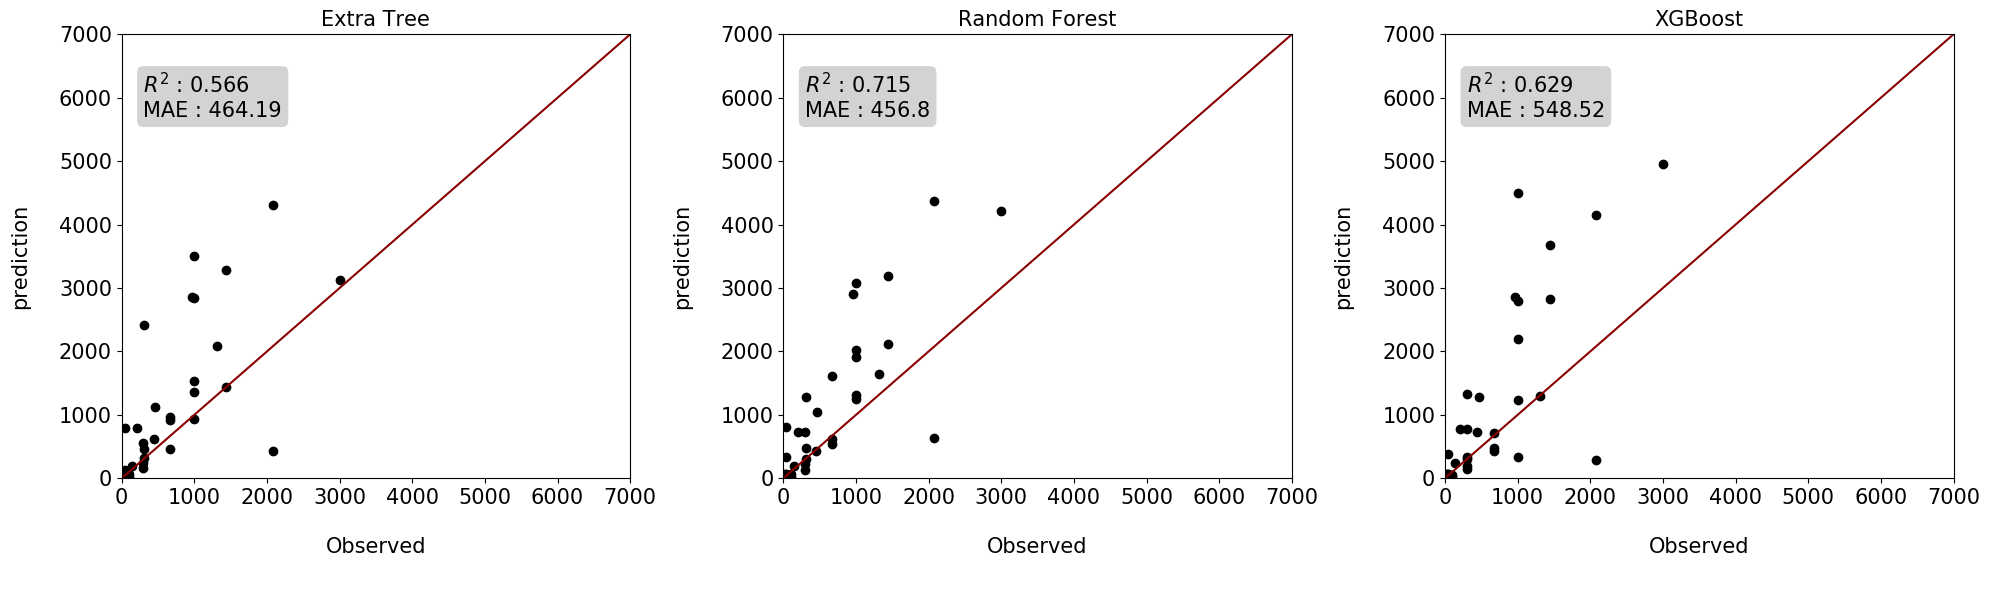

In [280]:
plt.figure(figsize = (20, 6))

pred_list = [pred_ex, pred_rf, pred_xg]
titles = ["Extra Tree", "Random Forest", "XGBoost"]

for i in range(len(pred_list)) :
    const_pred = sm.add_constant(pred_list[i], has_constant = "add")
    pred_ols = sm.OLS(test_y, const_pred).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x
    
    plt.subplot(1, 3, i+1)
    plt.scatter(test_y, pred_list[i], color = "black")
    plt.xlim(0, 7000) ; plt.ylim(0, 7000)
#     plt.plot(linear_x, linear_y, color = "darkred", linestyle = "--", linewidth = 3)
    plt.plot([0, 7000], [0, 7000], color = "darkred")
    plt.xlabel("\nObserved\n", fontsize = 15)  ; plt.ylabel("prediction\n", fontsize = 15)
    plt.xticks(fontsize = 15)  ; plt.yticks(fontsize = 15) ; plt.title(titles[i], fontsize = 15)

    plt.text(300, 5700,
             #"y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
             "$R^2$" + " : " + str(np.round(pred_ols.rsquared, 3)) + 
             "\nMAE : " + str(np.round(MAE(test_y, pred_list[i]), 2)),
             fontsize = 15,
             bbox = dict(facecolor = "lightgray", edgecolor = 'none', boxstyle = 'round', alpha = 1))

plt.tight_layout()
plt.show()

## **_LOOCV**

In [70]:
X = pre_data.drop(["complex odor"], axis = 1)
y = pre_data["complex odor"]
preds = []

for i in tqdm(range(X.shape[0])) : 
    test_X, test_y = X.iloc[i, :], y[i]
    train_X, train_y = X.drop(index = i), y.drop(index= i)
    
    X_std = StandardScaler().fit(train_X)
    train_X_std = pd.DataFrame(X_std.transform(train_X), columns = X.columns)
    test_X_std = pd.DataFrame(X_std.transform(np.array(test_X).reshape(1, -1)), columns = X.columns)
    model = RandomForestRegressor(random_state = 999).fit(train_X_std, np.ravel(train_y))
    pred = model.predict(test_X_std)[0]
    preds.append(pred)

print(len(preds))
print(preds[:10])

  0%|          | 0/212 [00:00<?, ?it/s]

212
[1249.03, 405.0844203899937, 309.1837352391583, 495.7080038106957, 45.15, 49.38, 83.37, 263.54194660686915, 131.1668054184884, 199.80276294169343]


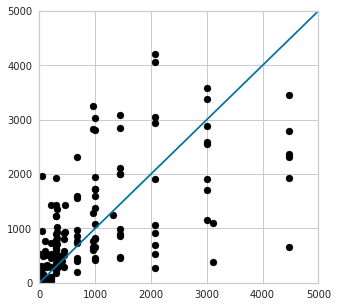

In [71]:
plt.figure(figsize = (5, 5))
plt.scatter(y, preds, color = "black")
plt.xlim(0,5000) ; plt.ylim(0,5000)
plt.plot([0, 5000], [0, 5000]);

In [72]:
loocv_r2 = R2(y, preds)
loocv_ols_r2 = OLS_R2(y, preds)
loocv_mae = RMSE(y, preds)

print(loocv_r2, loocv_ols_r2, loocv_mae)

0.638 0.414 909.641


# **[ XAI ]**

## **_Shap value**

In [187]:
# explainer = shap.TreeExplainer(model_rf)
# shap_values = explainer.shap_values(train_X)

In [258]:
# from matplotlib.pyplot import style
# style.use('seaborn-whitegrid')

# shap.initjs()
# shap.summary_plot(shap_values, train_X)

In [259]:
# shap.dependence_plot("Ammoina", shap_values, train_X, interaction_index = "Ammoina")
# shap.dependence_plot("Methyl mercaptan", shap_values, train_X, interaction_index = "Methyl mercaptan")

In [193]:
# shap.force_plot(explainer.expected_value, shap_values, test_X)

## **_PDP**

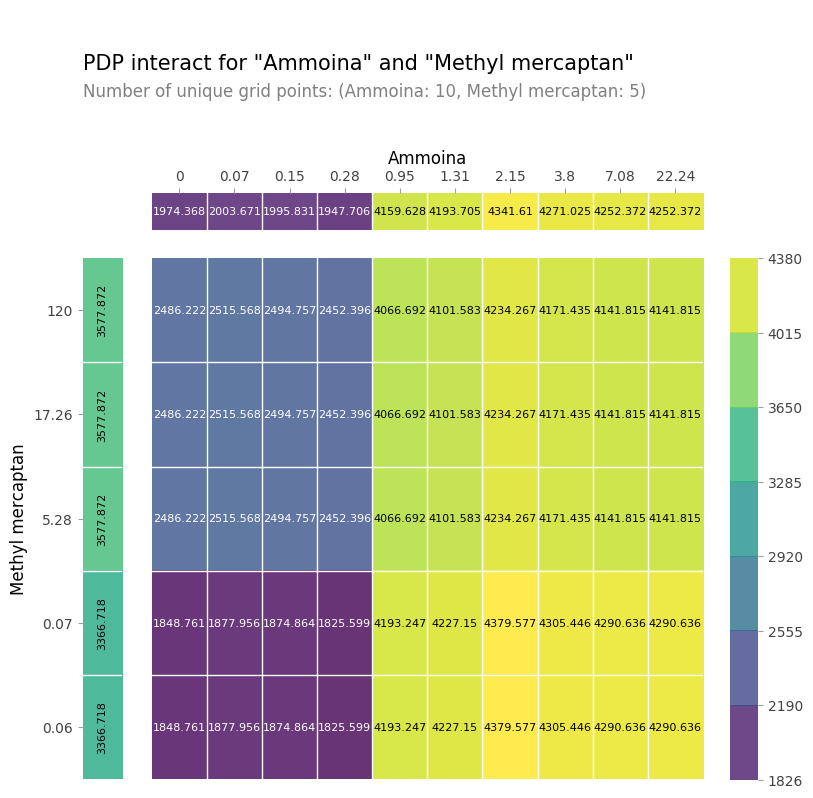

In [221]:
style.use('default')

pdp_interaction = pdp.pdp_interact(model = model_rf, dataset = pre_data.drop(["complex odor"], axis = 1), model_features = pre_data.columns[1:], features = ["Ammoina", "Methyl mercaptan"])

fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_interaction, feature_names = ["Ammoina", "Methyl mercaptan"], plot_type = "grid", x_quantile = True, plot_pdp = True,
                                  plot_params = {"inter_fontsize" : 8}, figsize = (8,10))

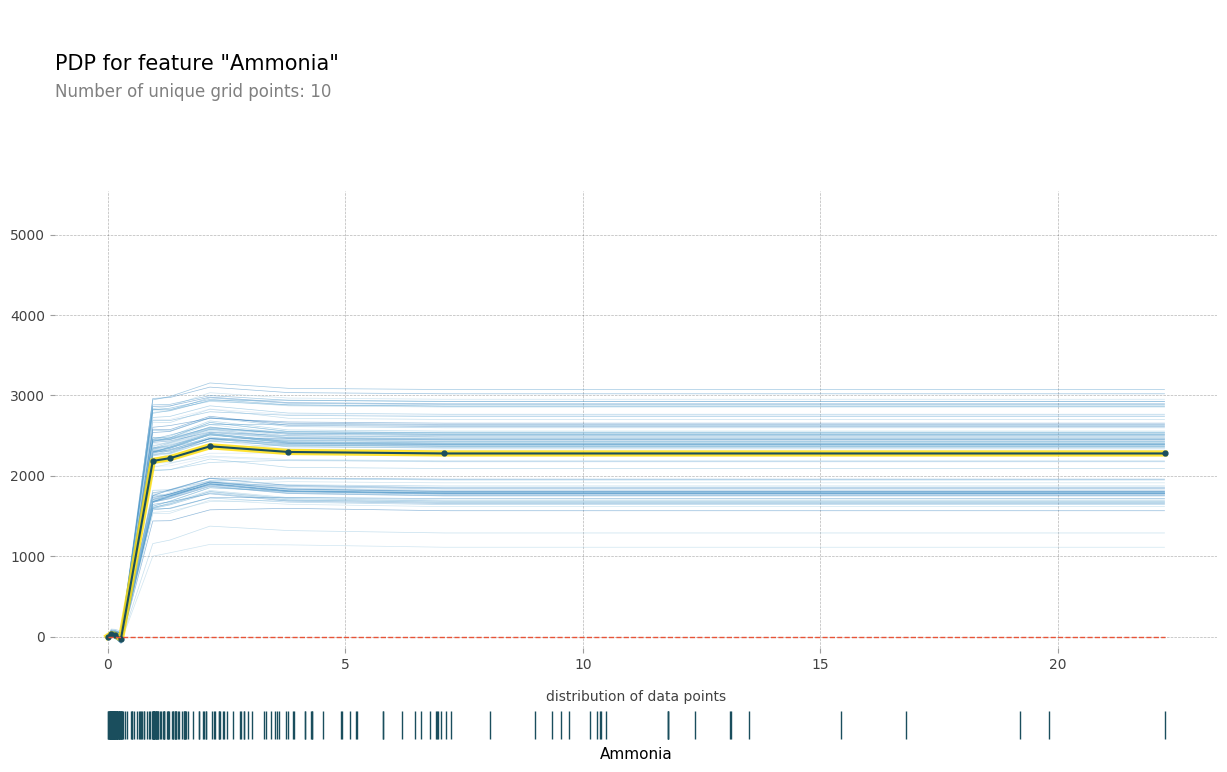

In [260]:
pdp_am = pdp.pdp_isolate(model = model_rf, dataset = pre_data.drop(["complex odor"], axis = 1), model_features = pre_data.columns[1:], feature = "Ammoina")
fig, axes = pdp.pdp_plot(pdp_am, "Ammonia", plot_lines = True, frac_to_plot = 0.5, plot_pts_dist = True)

# pdp_mm = pdp.pdp_isolate(model = model_rf, dataset = pre_data.drop(["complex odor"], axis = 1), model_features = pre_data.columns[1:], feature = "Methyl mercaptan")
# fig, axes = pdp.pdp_plot(pdp_mm, "Methyl mercaptan", plot_lines = True, frac_to_plot = 0.5, plot_pts_dist = True)